# Multithreading

## What are threads?
Threads are execution units within a process that can run simultaneously.

<img src="../imgs/processes_threads.png" width=400px>

While processes are entirely separate, threads run in a **shared memory** space.

## Starting Julia with multiple threads

By default, Julia starts with a single *user thread*. We must tell it explicitly to start multiple user threads. There are two ways to do this:

* Environment variable: `JULIA_NUM_THREADS=4`
* Command line argument: `julia -t 4` or, equivalently, `julia --threads 4`

**Jupyter lab:**

The simplest way is to globally set the environment variable `JULIA_NUM_THREADS` (e.g. in the `.bashrc`). But one can also create a specific Jupyter kernel for multithreaded Julia:

```julia
using IJulia
installkernel("Julia (4 threads)", env=Dict("JULIA_NUM_THREADS"=>"4"))
```

We can readily check how many threads we are running:

In [2]:
Threads.nthreads()

6

### User threads vs default threads

Technically, the Julia process is also spawning multiple threads already in "single-threaded" mode, like
* a thread for unix signal listening
* multiple OpenBLAS threads for BLAS/LAPACK operations

For this reason, we call the threads specified via `--threads` or the environment variable *user threads* or simply *Julia threads*.

## Task-based multithreading

Conceptually, Julia implements **task-based** multithreading. In this paradigm, a task - e.g. a computational piece of a code - is marked for parallel execution on **any** of the available Julia threads. Julias **dynamic scheduler** will automatically put the task on one of the threads and trigger the execution of the task on said thread.

Ideally, **a user should think about tasks and not threads**.

**Advantages:**
* high-level and convenient
* **composability / nestability** (Multithreaded code can call multithreaded code can call multithreaded code ....)

**Disadvantages:**
* **scheduling overhead**
* can get in the way when performance engineering
  * scheduler has limited information (e.g. about the system topology)
  * low-level profiling (e.g. with LIKWID) currently requires a known task -> thread -> cpu core mapping.

(Blog post: [Announcing composable multi-threaded parallelism in Julia](https://julialang.org/blog/2019/07/multithreading/))

### Spawning tasks on threads: `Threads.@spawn`
`Threads.@spawn` spawns a task on a Julia thread. Specifically, it creates (and immediately returns) a `Task` and schedules it for execution on an available Julia thread.

Note the conceptual similarity between `Threads.@spawn` (task -> thread) and `Distributed.@spawn` (task -> process) and also `@async`.

To avoid having to prefix `Threads.` to `@spawn` (and other threading-related functions) let's load everything from `Base.Threads` into global scope.

In [6]:
using Base.Threads

In [12]:
@spawn println("test")

Task (runnable) @0x0000000122238be0

test


While `Threads.@spawn` returns the task right away - it is **non-blocking** - the result might only be fetchable after some time.

In [13]:
t = @spawn begin
    sleep(3);
    "result"
end
@time fetch(t)

  2.983837 seconds (92 allocations: 2.484 KiB)


"result"

Note that we can use (some of) the control flow tools that we've already covered, like `@sync`.

In [14]:
@sync t = @spawn begin
    sleep(3);
    "result"
end
@time fetch(t)

  0.000004 seconds


"result"

In [16]:
for i in 1:2*nthreads()
    @spawn println("Hi, I'm ", threadid())
end

Hi, I'm 2
Hi, I'm 2
Hi, I'm 3
Hi, I'm 2
Hi, I'm 3
Hi, I'm 1
Hi, I'm 3
Hi, I'm 5
Hi, I'm 2
Hi, I'm 3
Hi, I'm 6
Hi, I'm 4


#### Example: Recursive Fibonacci series

$$ F(n) = F(n-1) + F(n-2), \qquad F(1) = F(2) = 1$$

We can nest `@spawn` calls freely!

In [376]:
function fib(n)
    n < 2 && return n
    t = @spawn fib(n-2)
    return fib(n-1) + fetch(t)
end

fib (generic function with 1 method)

In [377]:
fib.(1:10)

10-element Vector{Int64}:
  1
  1
  2
  3
  5
  8
 13
 21
 34
 55

(Note: Algorithmically, this is a highly inefficient implementation of the Fibonacci series, of course!)

#### Example: `tmap` (like `pmap`)

In [163]:
tmap(fn, itr) = map(fetch, map(i -> Threads.@spawn(fn(i)), itr))

tmap (generic function with 1 method)

In [164]:
using LinearAlgebra

In [165]:
M = [rand(200,200) for i in 1:10];

In [166]:
tmap(svdvals, M)

10-element Vector{Vector{Float64}}:
 [100.60811761375204, 8.319089812385856, 8.025879726699115, 7.796859140344441, 7.658762645674932, 7.600153309396105, 7.553530331512132, 7.39792438600115, 7.346760664405365, 7.259178649746093  …  0.2886726764660279, 0.2687608082957344, 0.22971289650515983, 0.2133110500321399, 0.15354367465072735, 0.1286428248187923, 0.09095696866651948, 0.07148636256785483, 0.034667579378330475, 0.013843535355437557]
 [99.73974995711129, 8.011137667436232, 7.931470859127419, 7.773729949415014, 7.633025556883976, 7.540632073156559, 7.5218878604444095, 7.374181604975084, 7.317970545390329, 7.218960789770793  …  0.2946325274466059, 0.2824079598746635, 0.2439993055976124, 0.1936448250029453, 0.13117527411674246, 0.10884173326983343, 0.08969352690310105, 0.07986392116014085, 0.05547804762216748, 0.04227470670702852]
 [100.34323872726455, 8.001498049266624, 7.878230267714143, 7.730141414174457, 7.558778111720865, 7.496175884138509, 7.465529390422066, 7.401999628223538, 7.30

In [167]:
tmap(i -> println(i, " ($(threadid()))"), 1:10);

4 (1)
3 (4)
6 (5)
2 (3)
10 (4)
5 (4)
8 (1)
7 (1)
1 (6)
9 (2)


Note, however, that this implementation creates temporary allocations and thus isn't particularly efficient.

In [168]:
@btime tmap($svdvals, $M);
@btime map($svdvals, $M);

  23.608 ms (145 allocations: 4.22 MiB)
  58.396 ms (81 allocations: 4.22 MiB)


#### Remarks on `@spawn`

* **Task migration**: Not only does the scheduler dynamically assign tasks to Julia threads, but it is also free to move tasks between threads. Hence, `threadid()` isn't necessarily constant over time and should be used with care!
* **Spawning tasks on specific threads**: Julia doesn't have a built-in tool for this (as of now). However, some packages like [ThreadPinning.jl](https://github.com/carstenbauer/ThreadPinning.jl) export `@tspawnat <threadid> ...` which allows to spawn *sticky* tasks.

In [145]:
using ThreadPinning

@tspawnat 3 println("running on thread ", threadid())

Task (runnable) @0x0000000124402620

running on thread 3


### Multithreading for-loops: `@threads`

Higher level interface to multithreading. (Compare `Distributed.@spawnat` vs `@distributed`)

In [148]:
@threads for i in 1:2*nthreads()
    println("Hi, I'm ", threadid())
end

Hi, I'm 2
Hi, I'm 1
Hi, I'm 2
Hi, I'm 5
Hi, I'm 6
Hi, I'm 4
Hi, I'm 6
Hi, I'm 3
Hi, I'm 2
Hi, I'm 3
Hi, I'm 4
Hi, I'm 5


In [380]:
using BenchmarkTools

function square!(x)
    for i in eachindex(x)
        x[i] = x[i]^2
    end
end

function square_threads!(x)
    @threads for i in eachindex(x)
        x[i] = x[i]^2
    end
end

x = rand(1_000_000)
@btime square!($x);
@btime square_threads!($x);

  303.735 μs (0 allocations: 0 bytes)
  106.622 μs (37 allocations: 2.91 KiB)


#### Scheduling options

Syntax: `@threads [schedule] for ...`

  * `:dynamic` (default)
    * creates O(`nthreads()`) many tasks each processing a contigious region of the iteration space
    * each task essentially spawned with `@spawn`
      * -> task migration
      * -> composability / nestability
    
  * `:static`
    * evenly splits up the iteration space and creates one task per block
    * **statically** maps tasks to threads, specifically: task 1 -> thread 1, task 2 -> thread 2, etc.
      * -> no task migration, i.e. **fixed task-thread mapping**
      * -> not composable / nestable
      * -> only little overhead

In [161]:
@threads :dynamic for i in 1:2*nthreads()
    println(i, " -> thread ", threadid())
end

7 -> thread 1
1 -> thread 2
9 -> thread 6
8 -> thread 2
11 -> thread 5
12 -> thread 5
2 -> thread 6
5 -> thread 4
6 -> thread 6
10 -> thread 2
3 -> thread 3
4 -> thread 4


In [160]:
@threads :static for i in 1:2*nthreads()
    println(i, " -> thread ", threadid())
end

1 -> thread 1
2 -> thread 1
5 -> thread 3
3 -> thread 2
6 -> thread 3
4 -> thread 2
9 -> thread 5
10 -> thread 5
11 -> thread 6
12 -> thread 6
7 -> thread 4
8 -> thread 4


For `@threads :static`, every thread handles precisely two iterations!

In [328]:
@threads :dynamic for i in 1:3
    @threads :dynamic for j in 1:3
        println("$i, $j")
    end
end

1, 3
3, 2
1, 1
2, 2
3, 1
2, 3
1, 2
2, 1
3, 3


In [329]:
@threads :static for i in 1:3
    @threads :static for j in 1:3
        println("$i, $j")
    end
end

LoadError: TaskFailedException

[91m    nested task error: [39m`@threads :static` cannot be used concurrently or nested
    Stacktrace:
     [1] [0m[1merror[22m[0m[1m([22m[90ms[39m::[0mString[0m[1m)[22m
    [90m   @ [39m[90mBase[39m [90m./[39m[90m[4merror.jl:35[24m[39m
     [2] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m./[39m[90m[4mthreadingconstructs.jl:91[24m[39m[90m [inlined][39m
     [3] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m./[39m[90m[4mIn[329]:2[24m[39m[90m [inlined][39m
     [4] [0m[1m(::var"#811#threadsfor_fun#412"{var"#811#threadsfor_fun#410#413"{UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m
     [5] [0m[1m#811#threadsfor_fun[22m
    [90m   @ [39m[90m./[39m[90m[4mthreadingconstructs.jl:51[24m[39m[90m [inlined][39m
     [6] [0m[1m(::Base.Threads.var"#1#2"{var"#811#threadsfor_fun#412"{var"#811#threadsfor_fun#410#413"{UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:30[24m[39m

### Load-balancing

In [319]:
function compute_nonuniform_spawn!(a, niter = zeros(Int, nthreads()), load = zeros(Int, nthreads()))
    @sync for i in 1:length(a)
        Threads.@spawn begin
            a[i] = sum(abs2, rand() for j in 1:i)
            
            # only for bookkeeping
            niter[threadid()] += 1
            load[threadid()] += i
        end
    end
    return niter, load
end

compute_nonuniform_spawn! (generic function with 3 methods)

In [322]:
a = zeros(nthreads()*20)
niter, load = compute_nonuniform_spawn!(a)

([0, 69, 28, 11, 12, 0], [0, 3488, 2032, 964, 776, 0])

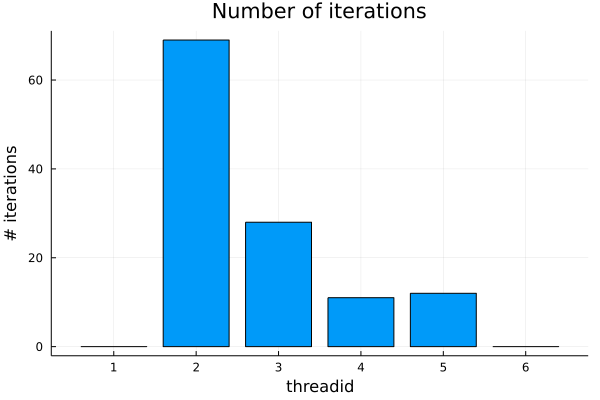

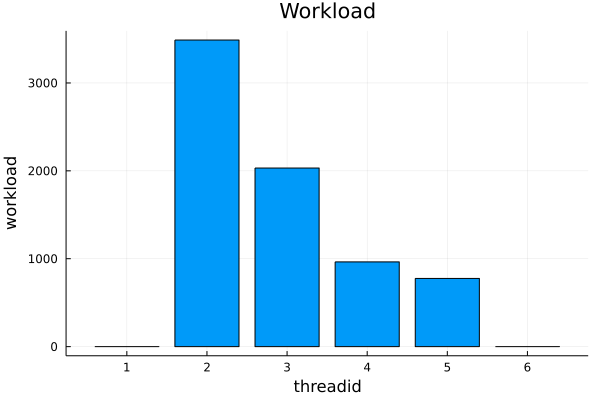

In [323]:
using Plots

b1 = bar(niter, xlab="threadid", ylab="# iterations", title="Number of iterations", legend=false)
b2 = bar(load, xlab="threadid", ylab="workload", title="Workload", legend=false)

display(b1)
display(b2)

In [324]:
function compute_nonuniform_threads!(a, niter = zeros(Int, nthreads()), load = zeros(Int, nthreads()))
    @threads for i in 1:length(a)
        a[i] = sum(abs2, rand() for j in 1:i)

        # only for bookkeeping
        niter[threadid()] += 1
        load[threadid()] += i
    end
    return niter, load
end

compute_nonuniform_threads! (generic function with 3 methods)

In [325]:
a = zeros(nthreads()*20)
niter, load = compute_nonuniform_threads!(a)

([20, 20, 20, 20, 20, 20], [1010, 1810, 2210, 610, 1410, 210])

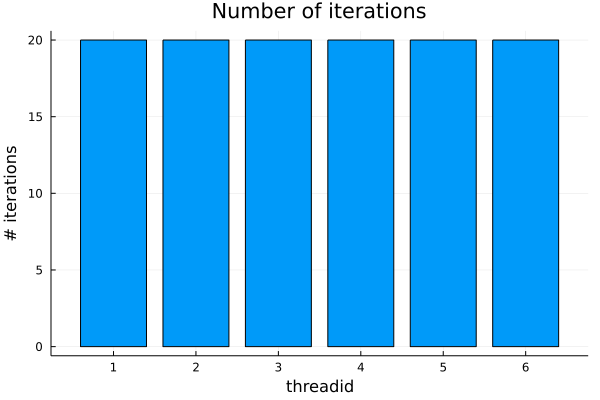

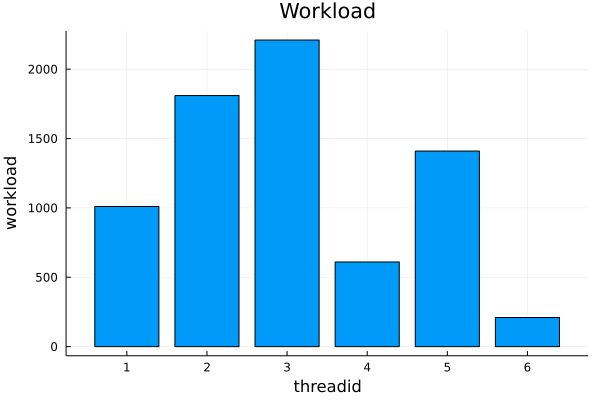

In [326]:
b1 = bar(niter, xlab="threadid", ylab="# iterations", title="Number of iterations", legend=false)
b2 = bar(load, xlab="threadid", ylab="workload", title="Workload", legend=false)

display(b1)
display(b2)

(There might be a scheduling option for `@threads` that implements load-balancing in the future.)

## Multithreading: Things to be aware of

### Race conditions and thread safety

In [21]:
function sum_serial(x)
    s = zero(eltype(x))
    for i in eachindex(x)
        @inbounds s += x[i]
    end
    return s
end

sum_serial (generic function with 1 method)

In [347]:
function sum_threads_naive(x)
    s = zero(eltype(x))
    @threads for i in eachindex(x)
        @inbounds s += x[i]
    end
    return s
end

sum_threads_naive (generic function with 1 method)

In [7]:
numbers = rand(nthreads()*10_000);

In [463]:
@show sum(numbers);
@show sum_serial(numbers);
@show sum_threads_naive(numbers);

sum(numbers) = 29950.9820756985
sum_serial(numbers) = 29950.982075698328
sum_threads_naive(numbers) = 5119.056466342457


**Wrong** result! Even worse, it's **non-deterministic** and different every time! It's also slow...

In [464]:
@btime sum_serial($numbers);
@btime sum_threads_naive($numbers);

  92.585 μs (0 allocations: 0 bytes)
  1.355 ms (120038 allocations: 1.83 MiB)


Reason: There is a [race condition](https://en.wikipedia.org/wiki/Race_condition).

Note that race conditions aren't specific to reductions. More generally, they can appear when multiple threads are modifying a shared "global" state simultaneously.

Not all of Julia and its packages in the ecosystem are thread-safe! In general, it is safer to assume that they're not unless proven otherwise.

#### Fix 1: Divide the work

In [465]:
function sum_threads_subsums(x)
    blocksize = length(x) ÷ nthreads()
    @assert isinteger(blocksize)
    idcs = collect(Iterators.partition(1:length(x), blocksize))
    
    subsums = zeros(eltype(x), nthreads())
    @threads for tid in 1:nthreads()
        for i in idcs[tid]
            @inbounds subsums[tid] += x[i]
        end
    end
    return sum(subsums)
end

sum_threads_subsums (generic function with 1 method)

In [466]:
@show sum(numbers);
@show sum_serial(numbers);
@show sum_threads_subsums(numbers);

sum(numbers) = 29950.9820756985
sum_serial(numbers) = 29950.982075698328
sum_threads_subsums(numbers) = 29950.982075698572


In [467]:
@btime sum_threads_subsums($numbers);

  33.499 μs (39 allocations: 3.36 KiB)


Speedup and correct result. But not ideal:

* cumbersome to do this manually
* can have more subtle performance issues like [false sharing](https://en.wikipedia.org/wiki/False_sharing#:~:text=In%20computer%20science%2C%20false%20sharing,managed%20by%20the%20caching%20mechanism.)

#### Fix 2: Atomics

See [Atomic Operations](https://docs.julialang.org/en/v1/manual/multi-threading/#Atomic-Operations) in the Julia doc for more information. But in generaly one shouldn't avoid using them as much as possible since they actually limit the parallelism.

### Garbage collection

[As of now](https://www.youtube.com/watch?v=Ks0p6PQyIPs), **Julia's GC is not parallel** and doesn't work nicely with multithreading.

If it gets triggered, it essentially "stops the world" (all threads) for clearing up memory.

Hence, when using multithreading, it is even more important to **avoid heap allocations!**

(If you can't avoid allocations, consider using multiprocessing instead.)

## High-level tools for parallel computing

### [ThreadsX.jl](https://github.com/tkf/ThreadsX.jl)

*Parallelized Base functions*

In [8]:
using ThreadsX

In [9]:
sum(numbers)

29927.1351724137

In [10]:
ThreadsX.sum(numbers)

29927.1351724137

In [13]:
@btime ThreadsX.sum($numbers);

  38.107 μs (541 allocations: 34.61 KiB)


### [FLoops.jl](https://github.com/JuliaFolds/FLoops.jl)

*Fast sequential, threaded, and distributed for-loops for Julia*

In [14]:
using FLoops

In [15]:
function sum_floops(x)
    @floop for xi in x
        @reduce(s = zero(eltype(x)) + xi)
    end
    return s
end

sum_floops (generic function with 1 method)

In [16]:
@btime sum_floops($numbers);

  33.051 μs (67 allocations: 3.91 KiB)


In [17]:
numbers = rand(nthreads()*10_000);

sum_floops(numbers) ≈ sum(numbers)

true

In [22]:
@btime sum_serial($numbers);
@btime sum_floops($numbers);

  92.581 μs (0 allocations: 0 bytes)
  32.646 μs (68 allocations: 3.94 KiB)


`@floop` supports different *executors* that allow for easy switching between serial and threaded execution

In [23]:
function sum_floops(x, executor)
    @floop executor for xi in x
        @reduce(s += xi)
    end
    return s
end

sum_floops (generic function with 2 methods)

In [24]:
@btime sum_floops($numbers, $(SequentialEx()));
@btime sum_floops($numbers, $(ThreadedEx()));

  92.580 μs (0 allocations: 0 bytes)
  32.144 μs (61 allocations: 3.83 KiB)


There are many more [executors](https://juliafolds.github.io/FLoops.jl/stable/tutorials/parallel/#tutorials-executor), like `DistributedEx` or `CUDAEx`. See, e.g., [FoldsThreads.jl](https://github.com/JuliaFolds/FoldsThreads.jl) and [FoldsCUDA.jl](https://github.com/JuliaFolds/FoldsCUDA.jl).

Under the hood, FLoops is built on top of [Transducers.jl](https://juliafolds.github.io/Transducers.jl/stable/tutorials/tutorial_parallel/) (i.e. it translates for-loop semantics into folds).

### [Tullio.jl](https://github.com/mcabbott/Tullio.jl)

*Tullio is a very flexible einsum macro* ([Einstein notation](https://en.wikipedia.org/wiki/Einstein_notation))

In [399]:
using Tullio

In [478]:
A = rand(10,10)
B = rand(10,10)

C = @tullio C[i,j] := A[i,k] * B[k,j] # matrix multiplication

C ≈ A * B

true

In [479]:
sum_tullio(xs) = @tullio S := xs[i]

sum_tullio (generic function with 1 method)

In [480]:
@btime sum_tullio($numbers);

  12.190 μs (0 allocations: 0 bytes)


(Uses `fastmath` and other tricks to be faster here.)

### [LoopVectorization.jl](https://github.com/JuliaSIMD/LoopVectorization.jl)

*Macro(s) for vectorizing loops.*

In [30]:
using LoopVectorization

In [31]:
function sum_turbo(x)
    s = zero(eltype(x))
    @tturbo for i in eachindex(x)
        @inbounds s += x[i]
    end
    return s
end

sum_turbo (generic function with 1 method)

In [34]:
@btime sum_turbo($numbers);

  4.817 μs (2 allocations: 48 bytes)


(Uses all kinds of SIMD tricks to be faster than the others.)

## System topology and thread affinity

### Hawk compute node

<img src="../imgs/lstopo_hawk.svg" width=100%>

**Not pinning threads (or pinning them badly) can degrade performance massively!**

### Pinning Julia threads to CPU threads

What about external tools like `numactl`, `taskset`, etc.? Doesn't work reliably because it [can't distinguish](https://discourse.julialang.org/t/thread-affinitization-pinning-julia-threads-to-cores/58069/5) between Julia threads and other internal threads.

**Options:**

* Environment variable: `JULIA_EXCLUSIVE=1` (compact pinning)
* More control and convenient visualization: [ThreadPinning.jl](https://github.com/carstenbauer/ThreadPinning.jl)
  * `compact`: pin to cpu thread 0, 1, 2, 3, ... one after another
  * `spread`: alternate between sockets so, e.g., 0, 64, 1, 65, 2, 66, .... (if a socket has 64 cores)
  * `numa`: same as `spread` but alternate between NUMA domains so, e.g., 0, 16, 32, 48, 64, .... (if a NUMA domain has 16 cores)
  * **Caveat:** currently one works on Linux.

<img src="../imgs/threadinfo.png" width=1000px>